In [1]:
import os
import io
import re
import matplotlib.pyplot as plt
import gensim
from six.moves import cPickle as pickle
import numpy as np
import scipy.stats as stats
import pandas as pd
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
truthful_pos = 'op_spam_v1.4/positive_polarity/truthful_from_TripAdvisor/'
truthful_neg = 'op_spam_v1.4/negative_polarity/truthful_from_Web/'

deceptive_pos = 'op_spam_v1.4/positive_polarity/deceptive_from_MTurk/'
deceptive_neg = 'op_spam_v1.4/negative_polarity/deceptive_from_MTurk/'

truthful_reviews_link = []
for fold in os.listdir(truthful_pos):
    foldLink = os.path.join(truthful_pos, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            truthful_reviews_link.append(fileLink)

for fold in os.listdir(truthful_neg):
    foldLink = os.path.join(truthful_neg, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            truthful_reviews_link.append(fileLink)

deceptive_reviews_link = []

for fold in os.listdir(deceptive_pos):
    foldLink = os.path.join(deceptive_pos, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            deceptive_reviews_link.append(fileLink)

for fold in os.listdir(deceptive_neg):
    foldLink = os.path.join(deceptive_neg, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            deceptive_reviews_link.append(fileLink)
        
print('Number of truthfuls reviews ', len(truthful_reviews_link))
print('Number of deceptives reviews ', len(deceptive_reviews_link))


Number of truthfuls reviews  800
Number of deceptives reviews  800


In [4]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def handleFile(filePath):
    with open(filePath, "r") as f:
        lines=f.readlines()
        file_voc = []
        file_numWords = 0
        for line in lines:
            cleanedLine = clean_str(line)
            cleanedLine = cleanedLine.strip()
            cleanedLine = cleanedLine.lower()
            words = cleanedLine.split(' ')
            file_numWords = file_numWords + len(words)
            file_voc.extend(words)
    return file_voc, file_numWords


allFilesLinks = truthful_reviews_link + deceptive_reviews_link
vocabulary = []
numWords = []
for fileLink in allFilesLinks:
    file_voc, file_numWords = handleFile(fileLink)
    vocabulary.extend(file_voc)
    numWords.append(file_numWords)

vocabulary = set(vocabulary)
vocabulary = list(vocabulary)

print('The total number of files is ', len(numWords))
print('The total number of words in the files is ', sum(numWords))
print('Vocabulary size is ', len(vocabulary))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is  1600
The total number of words in the files is  253157
Vocabulary size is  9687
The average number of words in the files is 158.223125


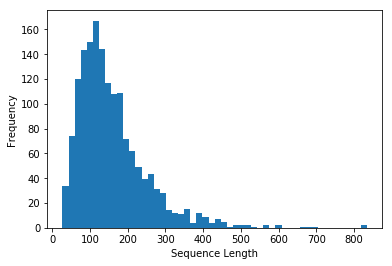

In [4]:
"""Visualize the data in histogram format"""
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
#plt.show()
plt.savefig("Sequence_Length vs Frequency.png")

In [5]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [6]:
MAX_SEQ_LENGTH = 200
def convertFileToIndexArray(filePath):
    doc = np.zeros(MAX_SEQ_LENGTH, dtype='int32')
    with open(filePath, "r") as f:
        lines=f.readlines()
        indexCounter = 0
        for line in lines:
            cleanedLine = clean_str(line)
            cleanedLine = cleanedLine.strip()
            cleanedLine = cleanedLine.lower()
            words = cleanedLine.split(' ')
            for word in words:
                doc[indexCounter] = vocabulary.index(word)
                indexCounter = indexCounter + 1
                if (indexCounter >= MAX_SEQ_LENGTH):
                    break
            if (indexCounter >= MAX_SEQ_LENGTH):
                break
    return doc

def convertFileToArray(filePath):
    s = ""
    with open(filePath, "r") as f:
        lines=f.readlines()
        for line in lines:
            cleanedLine = clean_str(line)
            cleanedLine = cleanedLine.strip()
            cleanedLine = cleanedLine.lower()
            s += cleanedLine
    return s

totalFiles = len(truthful_reviews_link) + len(deceptive_reviews_link)
idsMatrix = np.ndarray(shape=(totalFiles, MAX_SEQ_LENGTH), dtype='int32')
#dataMatrix = np.ndarray(shape=(totalFiles,1),dtype='object')
dataMatrix = []
labels = np.ndarray(shape=(totalFiles, 2), dtype='int32')
labelsMatrix = []
counter = 0
'''
for filePath in truthful_reviews_link:
    idsMatrix[counter] = convertFileToIndexArray(filePath)
    counter = counter + 1

for filePath in deceptive_reviews_link:
    idsMatrix[counter] = convertFileToIndexArray(filePath)
    counter = counter + 1
'''
for filePath in truthful_reviews_link:
    dataMatrix.append(convertFileToArray(filePath))
    labelsMatrix.append(1)
    #dataMatrix[counter] = convertFileToArray(filePath)
    #counter = counter + 1

for filePath in deceptive_reviews_link:
    dataMatrix.append(convertFileToArray(filePath))
    labelsMatrix.append(0)
    #dataMatrix[counter] = convertFileToArray(filePath)
    #counter = counter + 1

#labels[0:len(truthful_reviews_link)] = np.array([1, 0])
#labels[len(truthful_reviews_link):totalFiles] = np.array([0, 1])

#print('The shape of the data matrix is ', dataMatrix.shape)
#print('The shape of the labels is ', labels.shape)

dict_reviewLabels = {'review': dataMatrix,'labels': labelsMatrix}
df_reviewLabels = pd.DataFrame(dict_reviewLabels)
df_reviewLabels.head(2)



macronum=sorted(set(df_reviewLabels['labels']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))


def fun(i):
    return macro_to_id[i]

pd.set_option('mode.chained_assignment',None)
df_reviewLabels.iloc[:,0]=df_reviewLabels.iloc[:,0].apply(fun)
df_reviewLabels.head(2)



print(df_reviewLabels.shape)
# a list contains each review as a list 
balanced_texts = []
balanced_labels = []

for i in range(len(df_reviewLabels)):
    balanced_texts.append(df_reviewLabels.iloc[i,1])
    balanced_labels.append(df_reviewLabels.iloc[i,0])
 

#MAX_NB_WORDS = len(w2v_model.wv.vocab)
tokenizer = Tokenizer(num_words=2000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")#20000
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
x = pad_sequences(sequences, maxlen=200)#300
from keras.utils import to_categorical
labels = to_categorical(np.asarray(balanced_labels))
#y = df_reviewLabels['labels'].values
word_index = tokenizer.word_index

(1600, 2)


In [7]:
from keras.layers import Input, GlobalMaxPooling1D, Conv1D, Dropout, MaxPooling1D, Dense, Embedding, LSTM, Activation
from keras.models import Model, Sequential
from keras import optimizers
# Build embedding layers with weights initialized from each model
googlenews_w2v_size = 300
googlenews_w2v_matrix = np.zeros((len(word_index) + 1, googlenews_w2v_size))
for word,i in word_index.items():
    try:
        if word in w2v_model.vocab:
            googlenews_w2v_matrix[i] = w2v_model[word]
    except:
        pass

googlenews_w2v_emb = Embedding(len(word_index)+1,

                            googlenews_w2v_size,

                            weights=[googlenews_w2v_matrix],

                            input_length=200)


In [21]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * x.shape[0])

x_train = x[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = x[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


In [8]:

wordsVectors = []
notFoundwords = []
for word in vocabulary:
    try:
        vector = w2v_model[word]
        wordsVectors.append(vector)
    except Exception as e:
        notFoundwords.append(word)
        wordsVectors.append(np.random.uniform(-0.25,0.25,300))  

#del w2v_model
wordsVectors = np.asarray(wordsVectors)
print('The number of missing words is ', len(notFoundwords))

print('Found %s word vectors.' % len(wordsVectors))
words = list(w2v_model.wv.vocab)
print('Vocalbulary size %s' % len(words))

The number of missing words is  894
Found 9687 word vectors.
Vocalbulary size 3000000


/home/nhumair/.conda/envs/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [9]:
MAX_SEQ_LENGTH = 200
def convertFileToIndexArray(filePath):
    doc = np.zeros(MAX_SEQ_LENGTH, dtype='int32')
    with open(filePath, "r") as f:
        lines=f.readlines()
        indexCounter = 0
        for line in lines:
            cleanedLine = clean_str(line)
            cleanedLine = cleanedLine.strip()
            cleanedLine = cleanedLine.lower()
            words = cleanedLine.split(' ')
            for word in words:
                doc[indexCounter] = vocabulary.index(word)
                indexCounter = indexCounter + 1
                if (indexCounter >= MAX_SEQ_LENGTH):
                    break
            if (indexCounter >= MAX_SEQ_LENGTH):
                break
    return doc

def convertFileToArray(filePath):
    s = ""
    with open(filePath, "r") as f:
        lines=f.readlines()
        for line in lines:
            cleanedLine = clean_str(line)
            cleanedLine = cleanedLine.strip()
            cleanedLine = cleanedLine.lower()
            s += cleanedLine
    return s

totalFiles = len(truthful_reviews_link) + len(deceptive_reviews_link)
idsMatrix = np.ndarray(shape=(totalFiles, MAX_SEQ_LENGTH), dtype='int32')
#dataMatrix = np.ndarray(shape=(totalFiles,1),dtype='object')
dataMatrix = []
labels = np.ndarray(shape=(totalFiles, 2), dtype='int32')
labelsMatrix = []
counter = 0
'''
for filePath in truthful_reviews_link:
    idsMatrix[counter] = convertFileToIndexArray(filePath)
    counter = counter + 1

for filePath in deceptive_reviews_link:
    idsMatrix[counter] = convertFileToIndexArray(filePath)
    counter = counter + 1
'''
for filePath in truthful_reviews_link:
    dataMatrix.append(convertFileToArray(filePath))
    labelsMatrix.append(1)
    #dataMatrix[counter] = convertFileToArray(filePath)
    #counter = counter + 1

for filePath in deceptive_reviews_link:
    dataMatrix.append(convertFileToArray(filePath))
    labelsMatrix.append(0)
    #dataMatrix[counter] = convertFileToArray(filePath)
    #counter = counter + 1

#labels[0:len(truthful_reviews_link)] = np.array([1, 0])
#labels[len(truthful_reviews_link):totalFiles] = np.array([0, 1])

#print('The shape of the data matrix is ', dataMatrix.shape)
#print('The shape of the labels is ', labels.shape)

dict_reviewLabels = {'review': dataMatrix,'labels': labelsMatrix}
df_reviewLabels = pd.DataFrame(dict_reviewLabels)
df_reviewLabels.head(2)

,labels,review
0,1,we stay at hilton for 4 nights last march it w...
1,1,this is a stunning hotel in an excellent locat...


In [10]:
macronum=sorted(set(df_reviewLabels['labels']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))


def fun(i):
    return macro_to_id[i]

pd.set_option('mode.chained_assignment',None)
df_reviewLabels.iloc[:,0]=df_reviewLabels.iloc[:,0].apply(fun)
df_reviewLabels.head(2)

,labels,review
0,1,we stay at hilton for 4 nights last march it w...
1,1,this is a stunning hotel in an excellent locat...


In [11]:
# a list contains each review as a list 
balanced_texts = []
balanced_labels = []

for i in range(len(df_reviewLabels)):
    balanced_texts.append(df_reviewLabels.iloc[i,1])
    balanced_labels.append(df_reviewLabels.iloc[i,0])

In [17]:

            
'''            
# Model Hyperparameters
SENTENCE_PER_REVIEW = 16
WORDS_PER_SENTENCE = 10
EMBEDDING_DIM = 300
FILTER_WIDTHS_SENT_CONV = np.array([3, 4, 5])
NUM_FILTERS_SENT_CONV = 100
FILTER_WIDTHS_DOC_CONV = np.array([3, 4, 5])
NUM_FILTERS_DOC_CONV = 100
NUM_CLASSES = 2
DROPOUT_KEEP_PROB = 0.5
L2_REG_LAMBDA = 0.0
BATCH_SIZE = 64
NUM_EPOCHS = 100
EVALUATE_EVERY = 100   # Evaluate model on the validation set after 100 steps
CHECKPOINT_EVERY = 100 # Save model after each 200 steps
NUM_CHECKPOINTS = 5    # Keep only the 5 most recents checkpoints
LEARNING_RATE = 1e-3   # The learning rate
'''

# Model Hyperparameters
SENTENCE_PER_REVIEW = 16
WORDS_PER_SENTENCE = 10
EMBEDDING_DIM = 300
FILTER_WIDTHS_SENT_CONV = np.array([3, 4, 5])
NUM_FILTERS_SENT_CONV = 100
FILTER_WIDTHS_DOC_CONV = np.array([3, 4, 5])
NUM_FILTERS_DOC_CONV = 100
NUM_CLASSES = 2
DROPOUT_KEEP_PROB = 0.5
L2_REG_LAMBDA = 0.0
BATCH_SIZE = 64
NUM_EPOCHS = 100
EVALUATE_EVERY = 100   # Evaluate model on the validation set after 100 steps
CHECKPOINT_EVERY = 100 # Save model after each 200 steps
NUM_CHECKPOINTS = 5    # Keep only the 5 most recents checkpoints
LEARNING_RATE = 1e-3   # The learning rate


In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = len(w2v_model.wv.vocab)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)#20000
tokenizer.fit_on_texts(dataMatrix)
sequences = tokenizer.texts_to_sequences(dataMatrix)
data = pad_sequences(sequences, maxlen=200)#300

/home/nhumair/.conda/envs/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
from keras.utils import to_categorical
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
labels = to_categorical(np.asarray(labelsMatrix))
#labels = np.array(balanced_labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 9682 unique tokens.
Shape of data tensor: (1600, 200)
Shape of label tensor: (1600, 2)


In [25]:
print(wordsVectors)

[[-0.18457031 -0.15917969  0.25195312 ... -0.01086426 -0.15527344
   0.20703125]
 [-0.18945312  0.18164062  0.3359375  ...  0.11669922  0.05688477
   0.10546875]
 [-0.05834961  0.06787109 -0.05395508 ...  0.08447266  0.02307129
   0.24316406]
 ...
 [ 0.07568359  0.2265625   0.18652344 ...  0.14355469 -0.08935547
   0.28320312]
 [-0.0168457   0.09521484 -0.13085938 ... -0.11865234  0.26367188
   0.15820312]
 [ 0.24023438  0.0025177  -0.10107422 ...  0.31445312 -0.28710938
   0.25      ]]


In [8]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
from keras.preprocessing.sequence import pad_sequences
#import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    #text = re_url.sub("URL", text)
    
    # replace IPs
    #text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_text(list_sentences, lower=False):
    textList = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        textList.append(txt)
    return textList


#list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
#list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

texts = process_text(balanced_texts)
print("The vocabulary contains {} unique tokens".format(len(vocab)))

100%|██████████| 1600/1600 [00:00<00:00, 7866.90it/s]

The vocabulary contains 9603 unique tokens


In [9]:
'''
#code from yelp dataset preprocessing

#prepare embedding matrix
EMBEDDING_DIM = 300
#num_words = min(20000, len(word_index)) + 1
#embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > 20000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
        
'''     
      
MAX_NB_WORDS = len(w2v_model.wv.vocab)        
WV_DIM = 100
word_vectors = w2v_model.wv
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

sequences = [[word_index.get(t, 0) for t in text]
             for text in texts[:len(texts)]]
#test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  #for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, 
                     padding="pre", truncating="post")

#MAX_NB_WORDS = len(w2v_model.wv.vocab)
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
#wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
#wv_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
wv_matrix = np.random.random((len(word_index) + 1, WV_DIM))
for word, i in word_index.items():
    
    if i >= MAX_NB_WORDS:
        continue
    
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass        


/home/nhumair/.conda/envs/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/nhumair/.conda/envs/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [31]:
from keras.layers import Embedding
MAX_SEQ_LENGTH = 200
embedding_layer = Embedding(len(word_index)+1, WV_DIM,weights=[wv_matrix],
                         input_length=MAX_SEQ_LENGTH,trainable=True)


In [32]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [33]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    Original taken from https://github.com/dennybritz/cnn-text-classification-tf/blob/master/data_helpers.py
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]


#batches = batch_iter(list(zip(x_train, y_train)), 64, 10)


batches_x = batch_iter(
            list(data), 32, 10)
batches_y = batch_iter(list(labels),32,10)




def data_gen(top_dim):
    """
    Generator to yield batches of two inputs (per sample) with shapes top_dim and 
    bot_dim along with their labels.
    """
    batch_size = 32
    while True:
        top_batch = []
        #bot_batch = []
        batch_labels = []
        for i in range(batch_size):
            # Create random arrays
            rand_pix = np.random.randint(100, 256)
            #top_img = np.full(top_dim, rand_pix)
            #bot_img = np.full(bot_dim, rand_pix)
            top_img = np.full(top_dim,fill_value=rand_pix)
            
            # Set a label
            label = np.random.choice([0, 1])
            batch_labels.append(label)

            # Pack each input image separately
            top_batch.append(top_img)
            #bot_batch.append(bot_img)

        yield np.array(top_batch), np.array(batch_labels)

print(x_train.shape)

(1280, 200)


In [36]:
# train a 1D convnet with global maxpooling
from keras.layers import Input, GlobalMaxPooling1D, Conv1D, Dropout, MaxPooling1D, Dense
from keras.models import Model
sequence_input = Input(shape=(x_train.shape[0],MAX_SEQ_LENGTH), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(macronum), activation='softmax')(x)
#preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
'''
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
'''

# split data into training and testing sets
#_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)
#for batch in batches:
            #x_batch, y_batch = zip(*batch)
    
my_gen = data_gen(x_train.shape)
#history = model.fit(batches_x, batches_y,batch_size=32,epochs=250,validation_data=(x_val, y_val))
history = model.fit_generator(my_gen,steps_per_epoch=10)




def batch_iter(data, labels, batch_size, shuffle=True):
    num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1

    def data_generator():
        data_size = len(data)
        while True:
            # Shuffle the data at each epoch
            if shuffle:
                shuffle_indices = np.random.permutation(np.arange(data_size))
                shuffled_data = data[shuffle_indices]
                shuffled_labels = labels[shuffle_indices]
            else:
                shuffled_data = data
                shuffled_labels = labels

            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                end_index = min((batch_num + 1) * batch_size, data_size)
                X, y = shuffled_data[start_index: end_index], shuffled_labels[start_index: end_index]
                yield X, y

    return num_batches_per_epoch, data_generator()


model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(macronum), activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
"""
    if mode == 'fit':
        model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_data=(x_test, y_test))
    else:
   """ 
train_steps, train_batches = batch_iter(x_train, y_train, batch_size)
valid_steps, valid_batches = batch_iter(x_test, y_test, batch_size)
model.fit_generator(train_batches, train_steps, epochs=1, validation_data=valid_batches, validation_steps=valid_steps)


ValueError: Input 0 is incompatible with layer conv1d_20: expected ndim=3, found ndim=4

In [15]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.6625
